# $\lambda$ Experiments


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [6]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines, stochastic_hamming_loss
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [7]:
# dataset_name='scene'
# dataset_name='yeast'
dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name, reduce_dim=200)

reducing dimension for TMC dataset
X_train: (21447, 200) y_train: (21447, 22)


### Baselines & Skylines

In [8]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, n_jobs=4)

/home/e.diemert/miniconda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# The Experiment

In [9]:
len(X_train)

21447

In [10]:
n_rollouts = 10

samples = [len(X_train)]
for _ in range(n_rollouts):
    samples += [int(samples[-1] / 2)]
samples = sorted([_ for _ in samples if _ > 100])

n_replays = 6  # actions per context
n_reruns = 5 # to account for action stochasticity
n_rollouts, samples

(10, [167, 335, 670, 1340, 2680, 5361, 10723, 21447])

In [11]:
crm_losses = np.ones((n_reruns, len(samples)))
crm_rewards = np.ones((n_reruns, len(samples)))

test_sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T
crm_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, test_sampling_probas, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)

for i in range(n_reruns):
    np.random.seed(i*42+1000)
    print(i, end='')
    
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
        
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
            crm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # learning
            crm_model.fit(
                crm_dataset, 
                lambda_ = .5,
                verbose = 0
            )
        # eval
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)
        crm_rewards[i,j] = crm_reward
        # next round
        start = end
    print()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)
crm_losses, crm_rewards

0........
1........
2........
3........
4........


(array([0.34022769, 0.31788179, 0.23362638, 0.30343965, 0.25247708,
        0.19380963, 0.11210481, 0.11249542]),
 array([0.83000324, 0.83000324, 0.83000324, 0.83000324, 0.83000324,
        0.83000324, 0.83000324, 0.83000324]))

In [22]:
scrm_losses = np.ones((n_reruns, len(samples)))
scrm_rewards = np.ones((n_reruns, len(samples)))
scrm_lambdas = np.ones((n_reruns, len(samples,)))

for i in range(n_reruns):
    np.random.seed(i*42+1000)
    print(i, end='')

    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            if j == 0:
                sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
            else:
                sampling_probas = scrm_model.predict_proba(X, y)
            scrm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # bench lambdas
            best_lambda = crm_model.cross_validate_lambda(scrm_dataset, 
                                                          len(X_train)*n_replays, 
                                                          grid=[1e-4, 1e-3, 1e-2, 1e-1, 1],
                                                          seed=i*42+1000+j, n_jobs=5)
            scrm_lambdas[i,j] = best_lambda
            # learning
            scrm_model.fit(
                scrm_dataset, 
                lambda_ = best_lambda,
                verbose = 0
            )
        # eval
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)
        scrm_rewards[i,j] = CRMDataset().update_from_supervised_dataset(
            X_test, y_test, scrm_model.predict_proba(X_test, np.ones_like(y_test)), n_samples=4
        ).rewards.sum()  / (len(X_test)*y_test.shape[1]*4)
        # next round
        start = end
    print()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)
#scrm_lambdas = scrm_lambdas.mean(axis=0)
scrm_losses, scrm_rewards, scrm_lambdas

0.

.......
1........
2........
3..

......
4........


(array([0.37679707, 0.41034408, 0.28727275, 0.30835827, 0.30634433,
        0.28578512, 0.26497949, 0.24539833]),
 array([0.62337072, 0.58969532, 0.71273986, 0.69172707, 0.69361227,
        0.71411513, 0.7350281 , 0.75463638]),
 array([[1.e-03, 1.e+00, 1.e-01, 1.e-04, 1.e-03, 1.e-03, 1.e+00, 1.e-03],
        [1.e-04, 1.e-02, 1.e-04, 1.e-02, 1.e-01, 1.e-01, 1.e+00, 1.e+00],
        [1.e-02, 1.e-02, 1.e-04, 1.e-01, 1.e+00, 1.e+00, 1.e-03, 1.e-02],
        [1.e-01, 1.e+00, 1.e+00, 1.e-02, 1.e+00, 1.e+00, 1.e-04, 1.e+00],
        [1.e-01, 1.e-02, 1.e-04, 1.e-01, 1.e-02, 1.e-01, 1.e+00, 1.e+00]]))

In [13]:
baseline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
baseline_rewards = np.ones_like(crm_losses)*baseline_reward

skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pistar.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
skyline_rewards = np.ones_like(crm_losses)*skyline_reward

map_skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        pistar.predict(X_test), n_samples=1
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*1)
for _ in range(10)])
map_skyline_rewards = np.ones_like(crm_losses)*map_skyline_reward

baseline_loss = stochastic_hamming_loss(pi0, X_test, y_test)
skyline_loss = stochastic_hamming_loss(pistar, X_test, y_test)

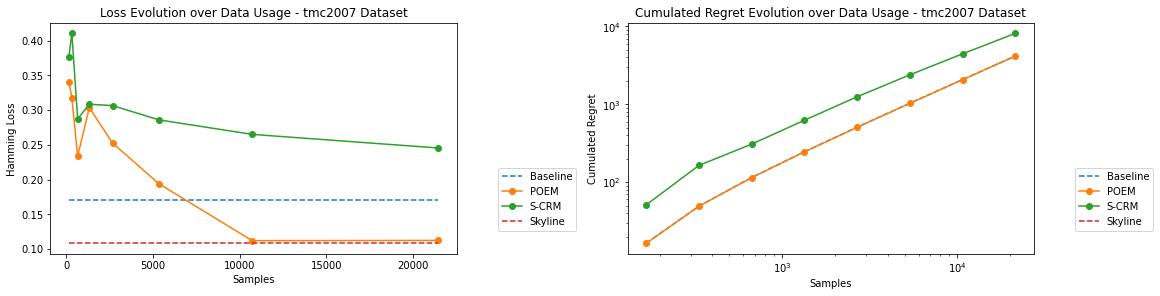

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(16,4))

ax1.set_title('Loss Evolution over Data Usage - %s Dataset' % dataset_name)
ax1.set_xlabel('Samples')
ax1.plot(samples, np.ones_like(crm_losses)*baseline_loss, '--', label='Baseline')
ax1.plot(samples, crm_losses, 'o-', label='POEM')
# ax1.plot(samples[1:], ucrm_losses, 'o-', label='POEM + Unif. Explo.')
ax1.plot(samples, scrm_losses, 'o-', label='S-CRM')
ax1.plot(samples, np.ones_like(crm_losses)*skyline_loss, '--', label='Skyline')
# ax1.plot(samples, np.ones_like(crm_losses)*map_skyline_loss, '--', label='Skyline (MAP)')
ax1.set_ylabel('Hamming Loss')
ax1.legend(loc=(1.1, .1))

ax2.set_title('Cumulated Regret Evolution over Data Usage - %s Dataset' % dataset_name)
ax2.set_xlabel('Samples')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*np.ones_like(crm_losses)*baseline_reward), '--', label='Baseline')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*crm_rewards), 'o-', label='POEM')
# ax2.plot(samples[1:], ucrm_rewards, 'o-', label='POEM + Unif. Explo.')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*scrm_rewards), 'o-', label='S-CRM')
ax2.plot(samples, np.zeros_like(samples*skyline_rewards), '--', label='Skyline')
ax2.set_ylabel('Cumulated Regret')
ax2.legend(loc=(1.1, .1))

Text(0, 0.5, '$\\lambda$')

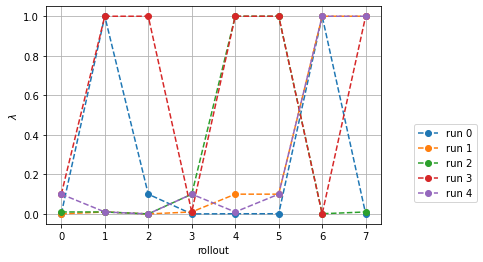

In [24]:
for j in range(scrm_lambdas.shape[0]):
    plt.plot(scrm_lambdas[j, :], 'o--', label='run %d' % j)
plt.legend(loc=(1.1,.1))
plt.grid()
plt.xlabel('rollout')
plt.ylabel('$\lambda$')